In [1]:
from IPython import display
from PIL import Image
from chainer.cuda import to_cpu
from chainer.dataset import concat_examples
from chainer.functions import mean_squared_error
from chainer.iterators import SerialIterator
from chainer.optimizers import Adam
from chainer.serializers import save_npz
from glob import glob
from time import time
from utils import Dataset, Model
import numpy as np

In [2]:
batch_size = 4
device = 0 # -1 for CPU or GPU ID (0, 1, etc.) for GPU
fp = (sorted(glob('../data_set/training_input/*.jpg')), sorted(glob('../data_set/training_ground-truth/*.jpg')))
frequency = 100 # display the results and save the model every [frequency] iterations
iterations = 400000

In [3]:
dataset = Dataset(fp)
iterator = SerialIterator(dataset, batch_size)

model = Model() if device < 0 else Model().to_gpu(device)
optimizer = Adam()

optimizer.setup(model)

iteration: 20000, loss: 763.8145141601562, time: 11067.679663181305.


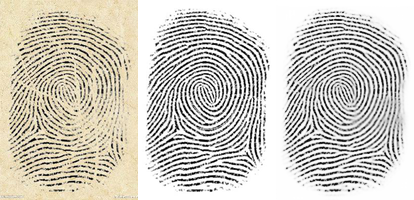

In [4]:
tic = time()

for i, batch in enumerate(iterator):
    x, y = concat_examples(batch, device)
    y_hat = model(x)
    loss = mean_squared_error(y, y_hat)

    model.cleargrads()
    loss.backward()
    optimizer.update()

    if (i + 1) % frequency == 0:
        display.clear_output()
        print('iteration: {}, loss: {}, time: {}.'.format(i + 1, float(loss.data), time() - tic))

        image = Image.new('RGB', (414, 200))

        image.paste(Image.fromarray(to_cpu(x[0]).astype('uint8').transpose(1, 2, 0)))
        image.paste(Image.fromarray(to_cpu(y[0, 0]).astype('uint8')), (138, 0))
        image.paste(Image.fromarray(to_cpu(y_hat.data[0, 0]).astype('uint8')), (276, 0))
        display.display(image)
        save_npz('../model.npz', model.copy().to_cpu())

    if i + 1 == iterations:
        break